# Introductie `xarray`

Deze notebook bevat een korte introductie van `xarray` de package waarmee we de data die we in `nlmod` bewerken wordt opgeslagen en beheerd.

De volgende onderwerpen komen aan bod:

- de twee basis data structuren in xarray: `Dataset` en `DataArray`
- hoe je interacteert met of bewerkingen doet op die data structuren
- visualisatie van de data
- wegschrijven en inlezen van data

Aan het einde van het notebook is een kleine opdracht opgenomen.

De eerste stap is het importeren van de packages. We importeren hier ook nlmod voor het ophalen van onze voorbeeld dataset.

In [1]:
import nlmod
import numpy as np
import xarray as xr

nlmod.util.get_color_logger("INFO");

Als voorbeeld gebruiken we REGIS data die we binnen een stukje van Nederland ophalen. De functie `get_regis()` van `nlmod` haalt REGIS op als `xarray.Dataset`.

In [2]:
# voorbeeld dataset is REGIS binnen een stukje van NL
extent = [118_000, 122_000, 473_000, 476_000]
ds = nlmod.read.get_regis(extent)
# ds.to_netcdf("regis.nc")

  ds.rio.set_crs(28992)



Waternet optie:

In [3]:
ds = xr.open_dataset("./data/regis.nc")

## `xarray` data structuren

Een `Dataset` is een soort dictionary met daarin zogenaamde `DataArrays` die ieder een eigen label (key) hebben. `Datasets` hebben een html-weergave waardoor we de inhoud in een notebook handig kunnen bekijken:

In [4]:
ds

<xarray.Dataset> Size: 424kB
Dimensions:  (y: 30, x: 40, layer: 29)
Coordinates:
  * x        (x) float64 320B 1.18e+05 1.182e+05 ... 1.218e+05 1.22e+05
  * y        (y) float64 240B 4.76e+05 4.758e+05 ... 4.732e+05 4.73e+05
  * layer    (layer) <U6 696B 'HLc' 'BXz3' 'BXz4' 'KRz3' ... 'OOz2' 'OOc' 'BRk1'
Data variables:
    top      (y, x) float32 5kB ...
    botm     (layer, y, x) float32 139kB ...
    kh       (layer, y, x) float32 139kB ...
    kv       (layer, y, x) float32 139kB ...
Attributes: (12/41)
    references:                    https://www.dinoloket.nl/regis-ii-het-hydr...
    Conventions:                   CF-1.7
    creator_url:                   https://www.dinoloket.nl
    keywords_vocabulary:           NASA/GCMD Earth Science Keywords. Version 6.0
    acknowledgment:                https://www.dinoloket.nl
    project:                       REGIS v02r2s2
    ...                            ...
    geospatial_vertical_min:       -1235.92
    geospatial_vertical_max:       322.75
    geospatial_vertical_units:     m-NAP
    geospatial_vertical_positive:  up
    gridtype:                      structured
    extent:                        [118000 122000 473000 476000]

We kunnen de `top` `DataArray` bekijken door deze uit de `Dataset` op te vragen net als in een dictionary:

In [5]:
ds["top"]

<xarray.DataArray 'top' (y: 30, x: 40)> Size: 5kB
[1200 values with dtype=float32]
Coordinates:
  * x        (x) float64 320B 1.18e+05 1.182e+05 ... 1.218e+05 1.22e+05
  * y        (y) float64 240B 4.76e+05 4.758e+05 ... 4.732e+05 4.73e+05
Attributes:
    long_name:      top
    standard_name:  depth_of_top_of_layer
    units:          mNAP
    grid_mapping:   crs
    source:         REGIS
    url:            https://dinodata.nl/opendap/REGIS/REGIS.nc
    date:           20240813

Een `DataArray` is eigenlijk een array met gelabelde dimensies en metadata. De dimensies van `top` zijn de `y` en `x` data.

De metadata staat opgeslagen onder de attributes, en daar staat bijvoorbeeld in dat de eenheid van de data meters NAP is.

In [27]:
top = ds["top"]
top.dims  # labels van de dimensies

('y', 'x')

In [28]:
# metadata, opgeslagen onder .attrs
top.attrs["units"]

'mNAP'

De ruimtelijke informatie (in dit geval) over de dimensies wordt opgeslagen onder `.coords`

In [8]:
top.coords

Coordinates:
  * x        (x) float64 320B 1.18e+05 1.182e+05 ... 1.218e+05 1.22e+05
  * y        (y) float64 240B 4.76e+05 4.758e+05 ... 4.732e+05 4.73e+05

Het ophalen van de coordinaten werkt eigenlijk het zelfde als voor de data variabelen zoals "top":

In [9]:
top["x"]

<xarray.DataArray 'x' (x: 40)> Size: 320B
array([118050., 118150., 118250., 118350., 118450., 118550., 118650., 118750.,
       118850., 118950., 119050., 119150., 119250., 119350., 119450., 119550.,
       119650., 119750., 119850., 119950., 120050., 120150., 120250., 120350.,
       120450., 120550., 120650., 120750., 120850., 120950., 121050., 121150.,
       121250., 121350., 121450., 121550., 121650., 121750., 121850., 121950.])
Coordinates:
  * x        (x) float64 320B 1.18e+05 1.182e+05 ... 1.218e+05 1.22e+05

Elke `DataArray` is eigenlijk een numpy.array met daaroverheen extra data. Om de numpy array op te halen gebruik je `.data`

In [10]:
top.data

array([[-4.59, -4.61, -4.79, ..., -2.1 , -2.2 , -2.29],
       [-4.77, -4.78, -4.85, ..., -2.2 , -2.2 , -2.34],
       [-4.87, -4.63, -4.56, ..., -2.16, -2.25, -2.41],
       ...,
       [-5.33, -5.32, -5.21, ..., -5.57, -5.72, -5.41],
       [-5.16, -5.09, -5.13, ..., -5.71, -5.66, -5.86],
       [-4.79, -4.72, -5.12, ..., -5.63, -5.53, -5.88]], dtype=float32)

## Indexing (selecteren) van data 

Maar wat kunnen we nu met deze `xarray` data structuren? Een handige toepassing is het selecteren van data op basis van een label of op basis van een index.

Het selecteren van data op basis van een index doe je met `.isel()`. Om de onderkant (`ds["botm"]`) van de bovenste laag te selecteren:

In [11]:
ds["botm"].isel(layer=0)

<xarray.DataArray 'botm' (y: 30, x: 40)> Size: 5kB
[1200 values with dtype=float32]
Coordinates:
  * x        (x) float64 320B 1.18e+05 1.182e+05 ... 1.218e+05 1.22e+05
  * y        (y) float64 240B 4.76e+05 4.758e+05 ... 4.732e+05 4.73e+05
    layer    <U6 24B 'HLc'
Attributes:
    long_name:      bottom
    standard_name:  depth_of_bottom_of_layer
    units:          mNAP
    grid_mapping:   crs
    source:         REGIS
    url:            https://dinodata.nl/opendap/REGIS/REGIS.nc
    date:           20240813

Maar dat kan ook op basis van de naam de laag. Dat heet label-based indexing en doe je met `.sel()`:

In [12]:
ds["botm"].sel(layer="HLc")

<xarray.DataArray 'botm' (y: 30, x: 40)> Size: 5kB
[1200 values with dtype=float32]
Coordinates:
  * x        (x) float64 320B 1.18e+05 1.182e+05 ... 1.218e+05 1.22e+05
  * y        (y) float64 240B 4.76e+05 4.758e+05 ... 4.732e+05 4.73e+05
    layer    <U6 24B 'HLc'
Attributes:
    long_name:      bottom
    standard_name:  depth_of_bottom_of_layer
    units:          mNAP
    grid_mapping:   crs
    source:         REGIS
    url:            https://dinodata.nl/opendap/REGIS/REGIS.nc
    date:           20240813

Als je meerdere lagen tegelijk wilt selecteren kan dat met `slice()`:

In [29]:
# bekijk eerst de lagen om te bedenken welke lagen je wilt selecteren:
ds['botm'].layer.data

array(['HLc', 'BXz3', 'BXz4', 'KRz3', 'URz1', 'URz2', 'URz3', 'URz4',
       'URz5', 'STz1', 'STk1', 'STz2', 'PZWAz1', 'WAk1', 'PZWAz2',
       'PZWAz3', 'PZWAz4', 'MSz1', 'MSk1', 'MSz2', 'MSk2', 'MSz3', 'MSc',
       'MSz4', 'OOz1', 'OOk1', 'OOz2', 'OOc', 'BRk1'], dtype='<U6')

In [14]:
# selecteren van Holoceen tot en met 3de zandlaag van formatie van Kreftenheye
ds["botm"].sel(layer=slice("HLc", "KRz3"))

<xarray.DataArray 'botm' (layer: 4, y: 30, x: 40)> Size: 19kB
[4800 values with dtype=float32]
Coordinates:
  * x        (x) float64 320B 1.18e+05 1.182e+05 ... 1.218e+05 1.22e+05
  * y        (y) float64 240B 4.76e+05 4.758e+05 ... 4.732e+05 4.73e+05
  * layer    (layer) <U6 96B 'HLc' 'BXz3' 'BXz4' 'KRz3'
Attributes:
    long_name:      bottom
    standard_name:  depth_of_bottom_of_layer
    units:          mNAP
    grid_mapping:   crs
    source:         REGIS
    url:            https://dinodata.nl/opendap/REGIS/REGIS.nc
    date:           20240813

We kunnen ook de laagindeling op een specifieke plek opvragen:

In [15]:
ds["botm"].sel(x=118_350, y=474_850)  # .to_pandas()

<xarray.DataArray 'botm' (layer: 29)> Size: 116B
[29 values with dtype=float32]
Coordinates:
    x        float64 8B 1.184e+05
    y        float64 8B 4.748e+05
  * layer    (layer) <U6 696B 'HLc' 'BXz3' 'BXz4' 'KRz3' ... 'OOz2' 'OOc' 'BRk1'
Attributes:
    long_name:      bottom
    standard_name:  depth_of_bottom_of_layer
    units:          mNAP
    grid_mapping:   crs
    source:         REGIS
    url:            https://dinodata.nl/opendap/REGIS/REGIS.nc
    date:           20240813

En als we gewoon een coordinaat willen intypen en de dichtstbijzijnde informatie willen opvragen gebruiken we `method="nearest"`:

In [16]:
top.sel(x=118_412, y=474_911, method="nearest")

<xarray.DataArray 'top' ()> Size: 4B
array(-5.21, dtype=float32)
Coordinates:
    x        float64 8B 1.184e+05
    y        float64 8B 4.75e+05
Attributes:
    long_name:      top
    standard_name:  depth_of_top_of_layer
    units:          mNAP
    grid_mapping:   crs
    source:         REGIS
    url:            https://dinodata.nl/opendap/REGIS/REGIS.nc
    date:           20240813

## Visualisatie

`xarray` bevat ook functionaliteit voor het visualiseren van data:

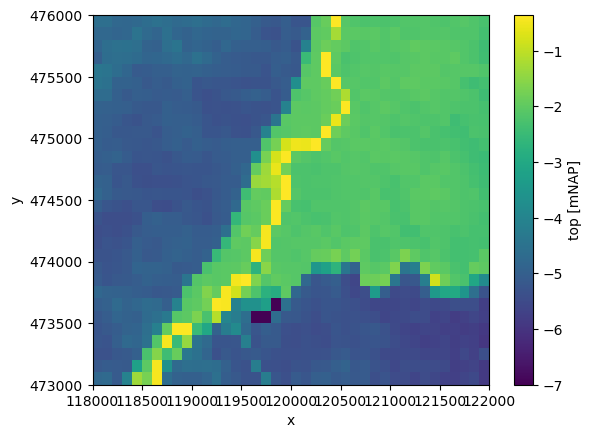

In [17]:
top.plot();

Als we eens doorsnede selecteren en plotten kunnen we zien waar welke laag voorkomt:

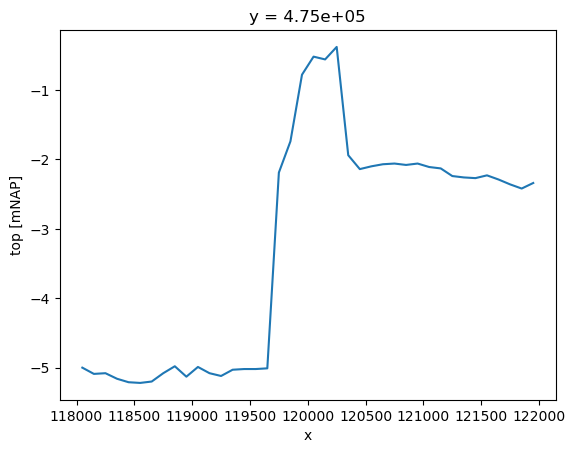

In [18]:
top.sel(y=474_911, method="nearest").plot();

Of we kunnen de bovenkant van de lagen als lijn plotten:

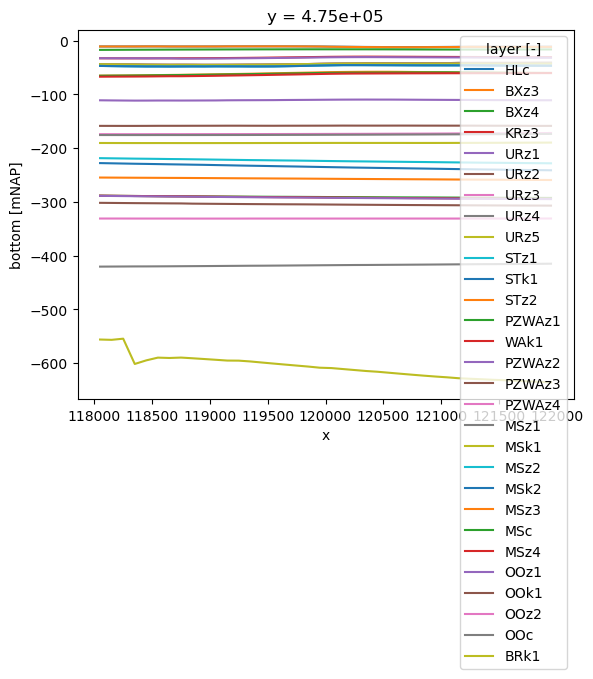

In [19]:
ds["botm"].sel(y=474_911, method="nearest").plot.line(x="x");

We kunnen ook de horizontale doorlatendheid in bovenaanzicht van meerdere lagen
tegelijk plotten:

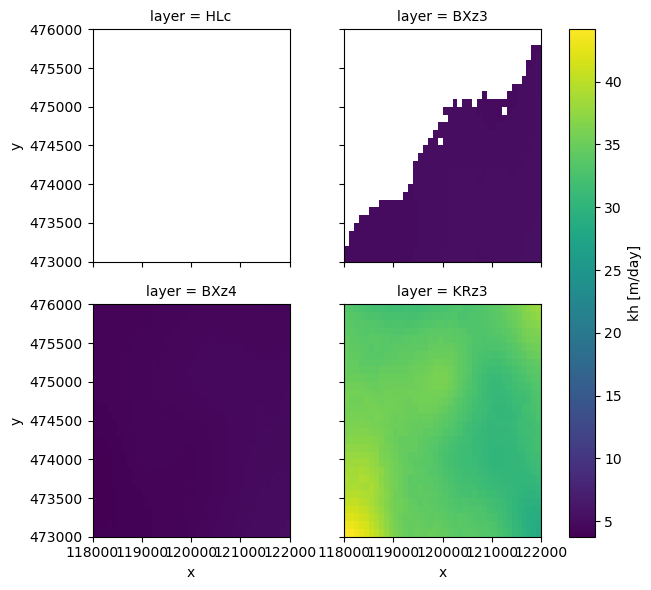

In [30]:
ds["kh"].sel(layer=slice("HLc", "KRz3")).plot(col="layer", col_wrap=2)

## Berekeningen

`xarray.DataArrays` werken verder heel vergelijkbaar als `numpy.arrays`. Je kan dus numpy functies toepassen op xarray objecten, maar xarray bevat zelf ook functies om berekeningen uit te voeren.

Bijvoorbeeld het gemiddelde niveau uitrekenen van de bovenste modellaag:

In [21]:
top.mean()

<xarray.DataArray 'top' ()> Size: 4B
array(-3.7421753, dtype=float32)

In [22]:
# hier komt hetzelfde uit
np.nanmean(top)

-3.7421753

Het handige aan xarray functies is dat je de naam van de dimensies waarover een operatie wil uitvoeren kan opgeven. Zo kan je dus bijvoorbeeld het gemiddelde diepte van de bovenkant van elke laag berekenen op deze manier:

In [23]:
ds["botm"].mean(dim=("y", "x"))

<xarray.DataArray 'botm' (layer: 29)> Size: 116B
array([ -10.823299,  -11.011108,  -16.256058,  -31.972702,  -32.608543,
        -43.82834 ,  -44.06364 ,  -44.102993,  -44.151634,  -48.747826,
        -48.764774,  -61.144897,  -61.394936,  -62.832134, -110.86435 ,
       -158.04211 , -172.44717 , -174.04231 , -189.45122 , -223.18456 ,
       -234.78227 , -256.15494 , -289.70865 , -290.4951  , -291.0186  ,
       -303.55612 , -329.77316 , -415.24536 , -599.3355  ], dtype=float32)
Coordinates:
  * layer    (layer) <U6 696B 'HLc' 'BXz3' 'BXz4' 'KRz3' ... 'OOz2' 'OOc' 'BRk1'

Ook simpele sommetjes kunnen we uitvoeren met deze data en opslaan in een nieuwe variabele. Bijvoorbeeld het verschil tussen de bovenkant van de eerste en de tweede laag.

In [24]:
thickness = top - ds["botm"].isel(layer=0)
thickness

<xarray.DataArray (y: 30, x: 40)> Size: 5kB
array([[6.67     , 6.64     , 6.4399996, ..., 9.74     , 9.570001 ,
        9.32     ],
       [6.4599996, 6.43     , 6.3399997, ..., 9.62     , 9.51     ,
        9.2699995],
       [6.3199997, 6.54     , 6.5899997, ..., 9.55     , 9.44     ,
        9.21     ],
       ...,
       [5.6000004, 5.5499997, 5.63     , ..., 4.56     , 4.48     ,
        4.8500004],
       [5.7799997, 5.79     , 5.6800003, ..., 4.45     , 4.6100006,
        4.52     ],
       [6.17     , 6.1700006, 5.7      , ..., 4.55     , 4.8299994,
        4.67     ]], dtype=float32)
Coordinates:
  * x        (x) float64 320B 1.18e+05 1.182e+05 ... 1.218e+05 1.22e+05
  * y        (y) float64 240B 4.76e+05 4.758e+05 ... 4.732e+05 4.73e+05
    layer    <U6 24B 'HLc'

## Opslaan en inlezen van data

`xarray` data kan je eenvoudig opslaan in NetCDF formaat met de functie `ds.to_netcdf()`

In [25]:
ds.to_netcdf("regis_dit_is_nieuw.nc")

En deze dataset kunnen we ook weer inlezen met `xr.open_dataset()`

In [26]:
ds2 = xr.open_dataset("regis_dit_is_nieuw.nc")

## Opdracht

Voer de volgende stappen uit, elke in een eigen code cel:

1. Bereken de dikte van alle lagen.
2. Bereken de gemiddelde dikte van alle lagen.
3. Selecteer de data in het gebied tussen xmin, xmax = (118,050, 120,050) en ymin, ymax = (473_050, 474_950). (Let hierbij op dat de y-data aflopend is, van hoog naar laag!)
4. Plot de dikte van de bovenste 4 lagen in bovenaanzicht.
5. Sla de dikte, berekend in stap 1, op als NetCDF bestand.
6. Lees dit bestand weer in en laat zien dat de het verschil in dikte van de bovenste laag tussen het ingelezen bestand en die uit stap 1 overal 0.0 is. 